In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-04-04_figures'
save = True

In [4]:
quants = {}

In [5]:
fn_quants = '../data/quantities_comparison.txt'
save = True

Names

In [6]:
name_gpurer = "\emph{{Gaia}} DR3 Quasars 'Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 'Purer'"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

Plotting variables

In [7]:
cmap_map = 'plasma'

Functions

In [8]:
def get_map(ras, decs):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

In [9]:
# via eqn 2, https://www.aanda.org/articles/aa/full_html/2015/02/aa23280-13/aa23280-13.html
def r_sdss_to_G_gaia(r):
    return 0.97 * r + 0.39

Map settings

In [10]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [11]:
G_hi = 20.5
G_lo = 20.0

# Figures

## Gaia purer

In [12]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [13]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [14]:
idx_Glim_gpurer = tab_gpurer['phot_g_mean_mag'] < G_hi
print(np.sum(idx_Glim_gpurer))

1493729


In [15]:
idx_has_zgaia = np.isfinite(tab_gpurer['redshift_qsoc'])
print(np.sum(idx_has_zgaia))

1729625


In [16]:
map_gpurer = get_map(tab_gpurer['ra'][idx_Glim_gpurer & idx_has_zgaia], 
                     tab_gpurer['dec'][idx_Glim_gpurer & idx_has_zgaia])

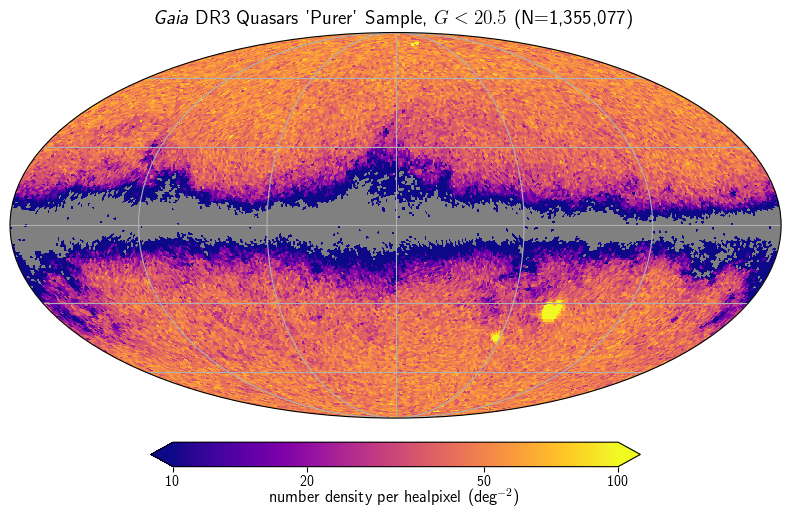

In [17]:
projview(map_gpurer, title=rf"{name_gpurer}, $G<{G_hi}$ (N={len(tab_gpurer[idx_Glim_gpurer & idx_has_zgaia]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=100, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50, 100])
fn = f'{plot_dir}/gpurer_Ghi_2d.png'
if save:
    plt.savefig(fn)

## SDSS DR16Q

In [18]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
print(f"Number of all SDSS quasars: {len(tab_sqall)}")

Number of all SDSS quasars: 638083


In [19]:
idx_Glim_sdss = r_sdss_to_G_gaia(tab_sqall['r_mag_sdss']) < G_hi
print(np.sum(idx_Glim_sdss))

298442


In [20]:
map_sdss = get_map(tab_sqall['ra_sdss'][idx_Glim_sdss], tab_sqall['dec_sdss'][idx_Glim_sdss])

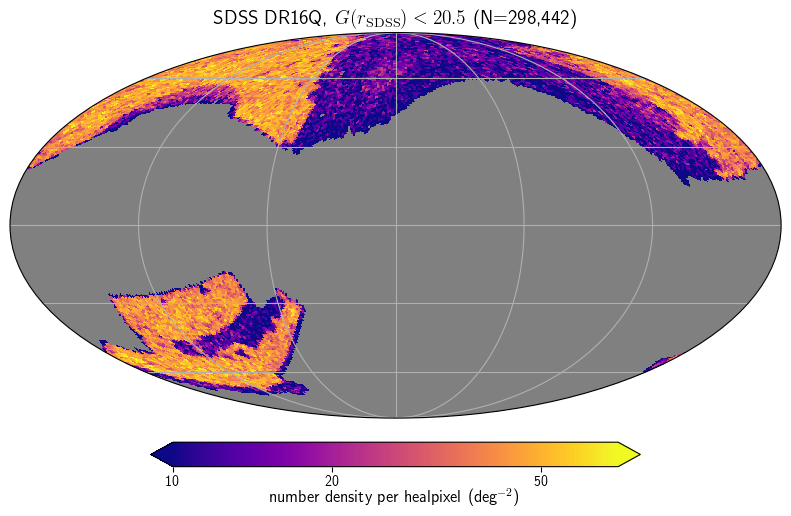

In [21]:
projview(map_sdss, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/sdss_Ghi_2d.png'
if save:
    plt.savefig(fn)

## WISE+PS

In [22]:
# downloaded from zenodo: https://zenodo.org/record/6998864#.ZDM78OzMJhE
fn_wiseps = '/scratch/ksf293/gaia-quasars-lss/data/PS1_WISE_QSO_photoz_catalog.csv'
tab_wiseps = Table.read(fn_wiseps, converters={'EXT': bool})

In [23]:
print(len(tab_wiseps))
idx_reliable = tab_wiseps['EXT']==False
print(np.sum(idx_reliable))

4849634
2879298


Great, matches abstract numbers! 

In [24]:
# documentation
tab_wiseps.columns

<TableColumns names=('objID_PS1','raMean','decMean','w1mpro','w1sigmpro','w1mag','w1sigm','w2mpro','w2sigmpro','w2mag','w2sigm','gFPSFMag','gFPSFMagErr','gFKronMag','gFKronMagErr','rFPSFMag','rFPSFMagErr','rFKronMag','rFKronMagErr','iFPSFMag','iFPSFMagErr','iFKronMag','iFKronMagErr','zFPSFMag','zFPSFMagErr','zFKronMag','zFKronMagErr','yFPSFMag','yFPSFMagErr','yFKronMag','yFKronMagErr','EBV_PS1','EXT','z_pred_mean','z_pred_std','spectroz')>

In [25]:
# PS1 r magnitude is very similar to SDSS r: https://outerspace.stsci.edu/display/PANSTARRS/PS1+Filter+properties
idx_Glim_wiseps = r_sdss_to_G_gaia(tab_wiseps['rFPSFMag']) < 20.4
print(np.sum(idx_Glim_wiseps))

1361982


In [26]:
map_wiseps = get_map(tab_wiseps['raMean'][idx_Glim_wiseps & idx_reliable], tab_wiseps['decMean'][idx_Glim_wiseps & idx_reliable])

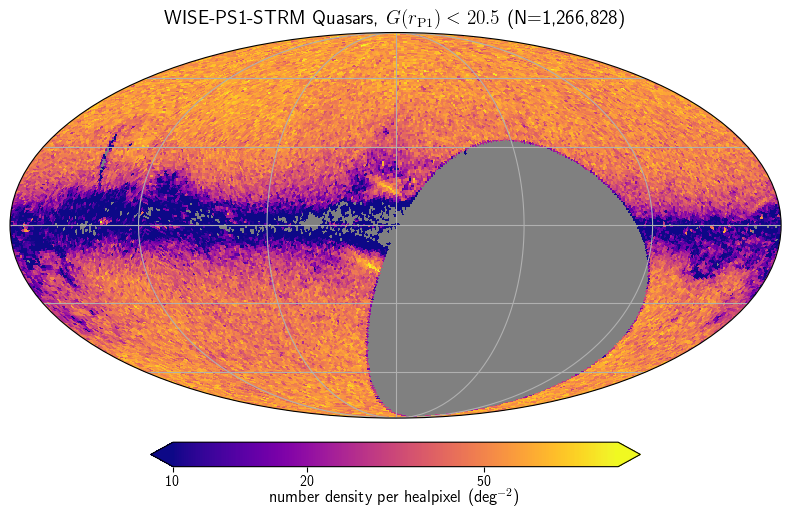

In [27]:
projview(map_wiseps, 
         title=rf"WISE-PS1-STRM Quasars, $G(r_\mathrm{{P1}}) < {G_hi}$ (N={len(tab_wiseps[idx_Glim_wiseps & idx_reliable]):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=100, norm='log', graticule=True,
         cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/wiseps_Ghi_2d.png'
if save:
    plt.savefig(fn)

# Milliquas

In [28]:
fn_mill = '../data/milliquas.fits.zip'
tab_mill = utils.load_table(fn_mill)
print(len(tab_mill))

1453164


In [29]:
print(tab_mill.columns)

<TableColumns names=('RA','DEC','NAME','TYPE','RMAG','BMAG','COMMENT','R','B','Z','CITE','ZCITE','RXPCT','QPCT','XNAME','RNAME','LOBE1','LOBE2')>


RMAG data is heterogeneous - from diff catalogs / filters. So we just use the SDSS conversion and hope it's close enough.

In [30]:
values, counts = np.unique(tab_mill['CITE'], return_counts=True)

ind = np.argpartition(-counts, kth=10)[:10]
for i in ind:
    print(values[i], counts[i])  # prints the 10 most frequent elements
    
print('total:',np.sum(counts))

DR16Q  717418
WISEA  31676
MQ     459068
DR16   43263
2QZ    27534
GAIA3  23730
NBCKv3 26784
XDQSO  21214
PGC    20303
2SLAQ  10367
total: 1453164


In [31]:
idx_Glim_mill = r_sdss_to_G_gaia(tab_mill['RMAG']) < G_hi
print(np.sum(idx_Glim_mill), len(idx_Glim_mill), np.sum(idx_Glim_mill)/len(idx_Glim_mill))
map_ndens_mill = get_map(tab_mill['RA'][idx_Glim_mill], tab_mill['DEC'][idx_Glim_mill])
N = len(tab_mill[idx_Glim_mill])

912050 1453164 0.6276304670360675


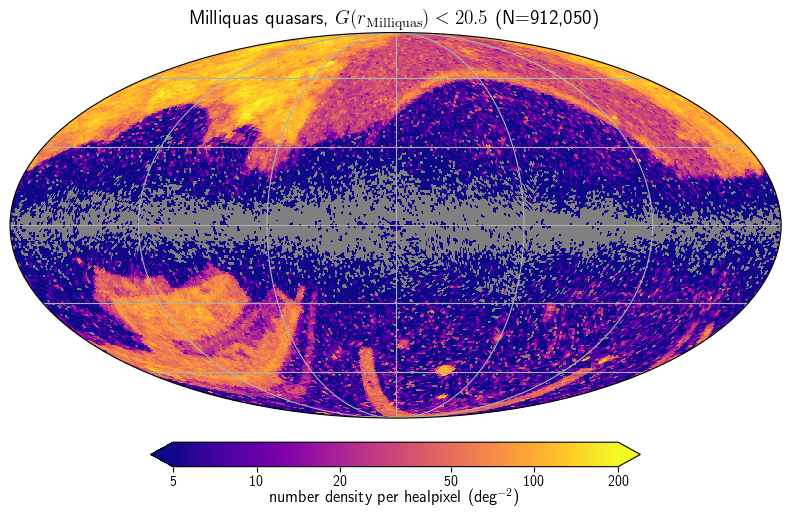

In [32]:
projview(map_ndens_mill, title=rf"Milliquas quasars, $G(r_\mathrm{{Milliquas}})<{G_hi}$ (N={N:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=200, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100, 200])

fn = f'{plot_dir}/milliquas_Ghi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Catalog quantities

### Numbers

In [33]:
frac_reliable = np.sum(idx_reliable)/len(idx_reliable)
p_reliable = round(100*frac_reliable)
quants['p_reliable_wiseps'] = p_reliable

### Redshifts

In [34]:
idx_has_specz = tab_wiseps['spectroz']!=-999
print(np.sum(idx_has_specz))

328677


In [35]:
def print_z_err_info(zs, zs_withspec, zs_spec):
    print(f"Median z: {np.median(zs):.3f}")
    
    threshs = [0.01, 0.1, 0.2, 0.5]
    dz = (zs_withspec - zs_spec)/(1 + zs_spec)
    n_tot = len(zs_spec)
    for thresh in threshs:
        n_below = np.sum(np.abs(dz) < thresh)
        print(fr'$f(|dz|<{thresh}) = {n_below/n_tot:.3f}$')

In [36]:
print_z_err_info(tab_wiseps['z_pred_mean'], 
                 tab_wiseps['z_pred_mean'][idx_has_specz], 
                 tab_wiseps['spectroz'][idx_has_specz])

Median z: 1.599
$f(|dz|<0.01) = 0.108$
$f(|dz|<0.1) = 0.706$
$f(|dz|<0.2) = 0.876$
$f(|dz|<0.5) = 0.982$


In [37]:
print_z_err_info(tab_wiseps['z_pred_mean'][idx_reliable], 
                 tab_wiseps['z_pred_mean'][idx_reliable&idx_has_specz], 
                 tab_wiseps['spectroz'][idx_reliable&idx_has_specz])

Median z: 1.411
$f(|dz|<0.01) = 0.110$
$f(|dz|<0.1) = 0.711$
$f(|dz|<0.2) = 0.880$
$f(|dz|<0.5) = 0.983$


# Investigating SDSS

In [38]:
np.min(map_sdss)

1.1914781026947956

In [39]:
npix_nonzero_sdss = np.sum(map_sdss>0)

In [40]:
area_sdss = npix_nonzero_sdss*area_per_pixel
print(area_sdss)

10596.921564436192


In [41]:
len(map_sdss)

49152

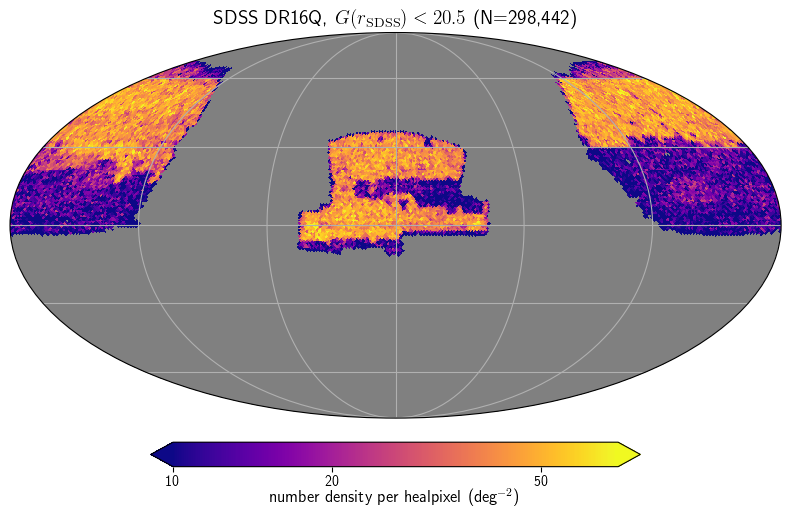

In [42]:
projview(map_sdss, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map,# coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])

In [43]:
idx_zmain = (tab_sqall['z_sdss'] > 0.8) & (tab_sqall['z_sdss'] < 3.5)

In [44]:
map_sdss_zmain = get_map(tab_sqall['ra_sdss'][idx_zmain], tab_sqall['dec_sdss'][idx_zmain])

In [45]:
np.min(map_sdss_zmain)

1.1914781026947956

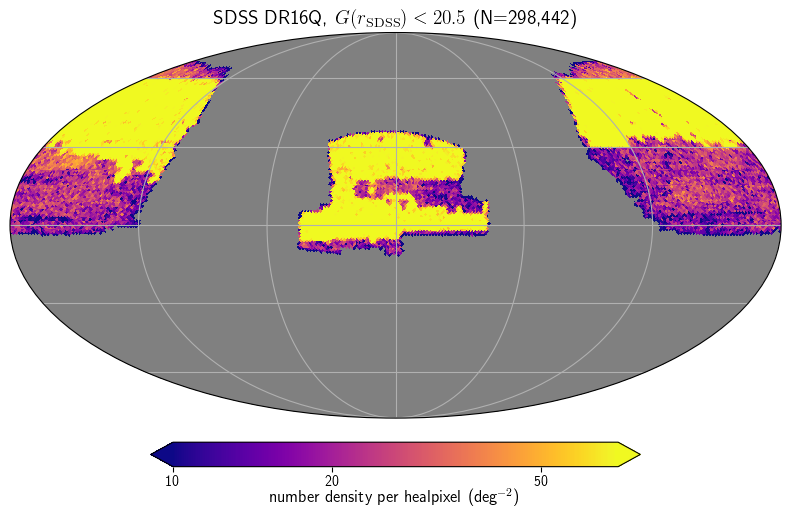

In [46]:
projview(map_sdss_zmain, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map,# coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])

In [48]:
tab_sdss = utils.load_table('../data/SDSS_DR16Q_v4.fits')

In [49]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

In [54]:
i_sdssiv = tab_sdss['MJD'] > 56898
print(np.sum(i_sdssiv), len(i_sdssiv))

387021 750414


In [57]:
i_zwarning0 = tab_sdss['ZWARNING'] == 0
print(np.sum(i_zwarning0), len(i_zwarning0))

638022 750414


In [59]:
print(np.sum(i_sdssiv & i_zwarning0))

362056


# Write quantities to file

In [47]:
with open(fn_quants, 'w') as f:
    for key, val in quants.items():
        print(key, val)
        if save:
            f.write(f'{key} = {val}\n')
if save:
    print()
    print(f"Saved to {fn_quants}!")

p_reliable_wiseps 59

Saved to ../data/quantities_comparison.txt!
